##Setup

In [0]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter
from PIL import Image
import os
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
from torch import nn, optim


In [0]:
# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
#         print(mid)

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

#             print("channel", idx, "start")
            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage
                    # print("cc", msg.control, msg.value, "duration", msg.time)

                if msg.type == "program_change":
                    timbre_register[idx] = msg.program
#                     print("channel", idx, "pc", msg.program, "time", time_counter, "duration", msg.time)



                if msg.type == "note_on":
#                     print("on ", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



					# When a note_on event *ends* the note start to be play 
					# Record end time of note_on event if there is no value in register
					# When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
					# When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
#                     print("off", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
					# fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(15, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self,filename):


        roll = self.get_roll()

        # build and set fig obj
        plt.ioff()
        fig = plt.figure(figsize=(15, 5))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
#         a1.set_facecolor("black")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
#         print(second)
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
#         print(x_label_period_sec)
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
#         print(x_label_interval)
        plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

        # change scale and label of y axis
        plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

        # build colors
        channel_nb = 1
        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(channel_nb)]

        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas


        # draw piano roll and stack image on a1
        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass

        # draw color bar

#         colors = [mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)) for i in range(channel_nb)]
#         cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, 16)
#         a2 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
#         cbar = mpl.colorbar.ColorbarBase(a2, cmap=cmap,
#                                         orientation='horizontal',
#                                         ticks=list(range(16)))

        # show piano roll
#         plt.draw()
#         plt.ion()
        plt.savefig('.\\maestro-v1.0.0\\IMAGES\\'+ filename)
#         plt.show(block=True)

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks

In [3]:
# Unzip IMAGES file

!unzip IMAGES.zip

Archive:  IMAGES.zip
   creating: IMAGES/
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--5.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--4.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.png  
  inflating: IMAGES/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.png  
  inflating:

In [0]:
%pwd

'/content'

In [0]:
imgpath = '/content/IMAGES/'

filenames = []

for i in os.listdir(imgpath):
    filenames.append(i)

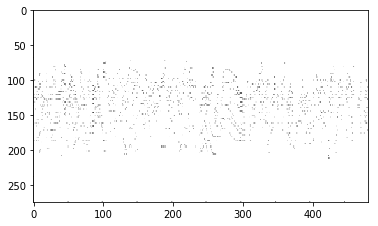

In [5]:
# 128 by 1000

image = Image.open(imgpath+filenames[0])
loader = transforms.Compose([transforms.Resize((360,640)),
                             transforms.CenterCrop((275,480)),
                             transforms.Grayscale(num_output_channels=1),
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),])


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
#     image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    
    return image  #assumes that you're using GPU

image = loader(image).float()

plt.imshow(image[0],cmap='gray')
plt.show()

tensor(1.)

In [0]:
# Get the training set tensors into a list
training_set = []

for i in filenames:
  training_set.append(image_loader(imgpath + i))

(1, 275, 480)

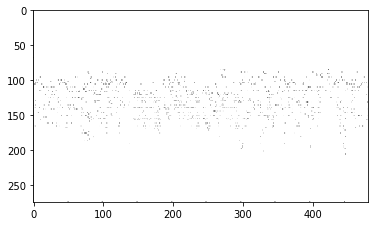

In [85]:
plt.imshow(training_set[100].detach().numpy().squeeze(),cmap='gray')

training_set[0].detach().numpy().shape

In [0]:
# Michael Dataset Extender
class Dataset_Handler(torch.utils.data.Dataset):
  def __init__(self, input_v):
    self.input = input_v


  def __len__(self):
    return len(self.input)

  def __getitem__(self, index):
    return self.input[index]

In [0]:
train_class = Dataset_Handler(training_set)

train = torch.utils.data.DataLoader(train_class, batch_size = 100, 
                                    shuffle = True)


def images_to_vectors(images):
    return images.view(images.size(0), 275*480)



In [88]:
# setup the GANs

#WGAN first

WG_G = torch.nn.Sequential(
    torch.nn.Linear(100, 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 1024),
    torch.nn.Linear(1024 , 2048),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(2048, 275*480),
    torch.nn.Tanh()
)

WG_D = torch.nn.Sequential(
    torch.nn.Linear(275 * 480, 2048),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(2048, 1024),
    torch.nn.Linear(1024 , 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 1)
)

WG_G_solver = optim.RMSprop(WG_G.parameters(), lr=0.0002)
WG_D_solver = optim.RMSprop(WG_D.parameters(), lr=0.0002)

WG_G.cuda()
WG_D.cuda()

Sequential(
  (0): Linear(in_features=132000, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2048, out_features=1024, bias=True)
  (3): Linear(in_features=1024, out_features=256, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=256, out_features=1, bias=True)
)

In [89]:
WG_D_loss_vec = []
WG_G_loss_vec = []

c = 10000000000000

for epoch in range(20):
  for n_batch, (real_batch) in enumerate(train):
      # Sample data
      N = real_batch.size(0)
      z = Variable(torch.randn(N, 100))
      X = Variable(images_to_vectors(real_batch))

      z = z.cuda()
      X = X.cuda()

      WG_D_solver.zero_grad()

      # Dicriminator
      G_sample = WG_G(z)
      D_real = WG_D(X)
      D_fake = WG_D(G_sample)

      # Discriminator loss
      D_loss = -torch.mean(D_real) + torch.mean(D_fake)
      
      WG_D_loss_vec.append(D_loss.item())
      
      D_loss.backward()
      WG_D_solver.step()
      
      for p in WG_D.parameters():
        p.data.clamp_(-c, c)

      # Generator
      WG_G_solver.zero_grad()

      G_sample = WG_G(z)
      D_fake = WG_D(G_sample)

      # Generator loss
      G_loss = -torch.mean((D_fake - 1))
      
      WG_G_loss_vec.append(G_loss.item())
      
      G_loss.backward()
      WG_G_solver.step()
  print('Epoch #', epoch, 'Complete')

Epoch # 0 Complete
Epoch # 1 Complete
Epoch # 2 Complete
Epoch # 3 Complete
Epoch # 4 Complete
Epoch # 5 Complete
Epoch # 6 Complete
Epoch # 7 Complete
Epoch # 8 Complete
Epoch # 9 Complete
Epoch # 10 Complete
Epoch # 11 Complete
Epoch # 12 Complete
Epoch # 13 Complete
Epoch # 14 Complete
Epoch # 15 Complete
Epoch # 16 Complete
Epoch # 17 Complete
Epoch # 18 Complete
Epoch # 19 Complete


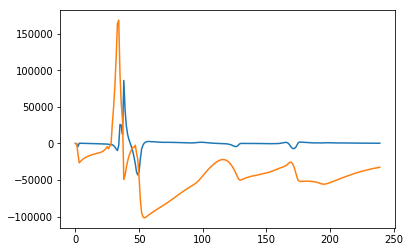

In [90]:
plt.plot(WG_D_loss_vec)
plt.plot(WG_G_loss_vec)

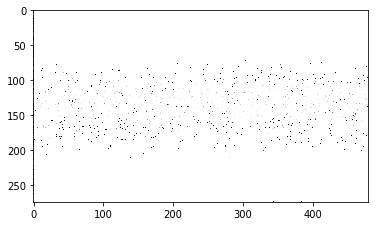

In [119]:
plt.imshow(G_sample[9].cpu().detach().numpy().reshape(275,480),cmap = 'gray')
plt.savefig("BEN_TEST.png")
plt.show()


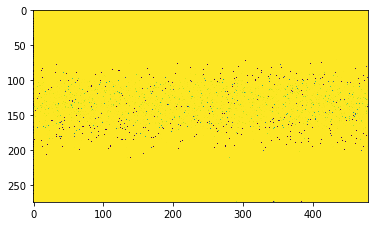

In [102]:
plt.imshow((G_sample[73] /2 + 0.5).cpu().detach().numpy().reshape(275,480))

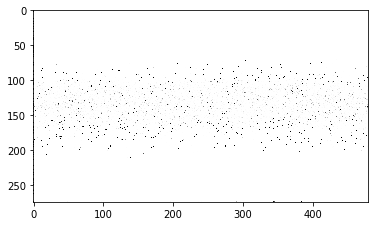

In [117]:
z = Variable(torch.randn(N, 100))
a = WG_G(z.cuda())

plt.imshow(a[0].cpu().detach().numpy().reshape(275,480),cmap = 'gray')
plt.

In [77]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


81.0

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [94]:
# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
# parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
# parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
# parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
# parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
# parser.add_argument("--channels", type=int, default=1, help="number of image channels")
# parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
# opt = parser.parse_args()
# print(opt)


_StoreAction(option_strings=['--n_epochs'], dest='n_epochs', nargs=None, const=None, default=200, type=<class 'int'>, choices=None, help='number of epochs of training', metavar=None)

In [75]:
# Implement DC GAN

DC_G = torch.nn.Sequential(
    nn.Linear(100, 256),
    nn.BatchNorm1d(256),
#     nn.Upsample(scale_factor=2),
    nn.Conv2d(256, 256, 3, stride=1, padding=1),
    nn.BatchNorm1d(256, 0.8),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(256, 128, 3, stride=1, padding=1),
    nn.BatchNorm1d(128, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 1, 3, stride=1, padding=1),
    torch.nn.Tanh()
)    



def discriminator_block(in_filters, out_filters, bn=True):
    block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
    if bn:
        block.append(nn.BatchNorm2d(out_filters, 0.8))
    return block

DC_D = torch.nn.Sequential(
    *discriminator_block(1, 16, bn=False),
    *discriminator_block(16, 32),
    *discriminator_block(32, 64),
    *discriminator_block(64, 128),
    
    nn.Linear(128 * 275 * 480, 1), 
    nn.Sigmoid()
)

# DC_G_solver = optim.RMSprop(DC_G.parameters(), lr=0.0002)
# DC_D_solver = optim.RMSprop(DC_D.parameters(), lr=0.0002)

optimizer_G = torch.optim.Adam(DC_G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(DC_D.parameters(), lr=0.0002, betas=(0.5, 0.999))


DC_G.cuda()
DC_D.cuda()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace)
  (2): Dropout2d(p=0.25)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace)
  (5): Dropout2d(p=0.25)
  (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): LeakyReLU(negative_slope=0.2, inplace)
  (9): Dropout2d(p=0.25)
  (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): LeakyReLU(negative_slope=0.2, inplace)
  (13): Dropout2d(p=0.25)
  (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=16896000, out_features=1, bias=True)
  (16): Sigmoid()
)

In [0]:
adversarial_loss = torch.nn.BCELoss()

In [17]:
DC_D_loss_vec = []
DC_G_loss_vec = []

for epoch in range(20):
  for n_batch, (real_batch) in enumerate(train):
      # Sample data
      N = real_batch.size(0)
      z = Variable(torch.randn(N, 100))
      X = Variable(images_to_vectors(real_batch))

      z = z.cuda()
      X = X.cuda()

      DC_D_solver.zero_grad()

      # Dicriminator
      G_sample = DC_G(z)
      D_real = DC_D(X)
      D_fake = DC_D(G_sample)

      # Discriminator loss
      real_loss = adversarial_loss(D_real, ones_target(N).cuda())
      fake_loss = adversarial_loss(D_fake, zeros_target(N).cuda())
      d_loss = (real_loss + fake_loss) / 2
      
      DC_D_loss_vec.append(d_loss)
      
      d_loss.backward()
      optimizer_D.step()

      # Generator
      optimizer_G.zero_grad()

      G_sample = DC_G(z)
      D_fake = DC_D(G_sample)

      # Generator loss
      G_loss = adversarial_loss(D_fake, ones_target(N).cuda())
      
      DC_G_loss_vec.append(G_loss.item())
      
      G_loss.backward()
      optimizer_G.step()
      
  print('Epoch #', epoch, 'Complete')

NotImplementedError: ignored

In [76]:
DC_G

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace)
  (5): Upsample(scale_factor=2.0, mode=nearest)
  (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace)
  (9): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): Tanh()
)

In [83]:
# DC_G(z.unsqueeze(1))
testing = z.unsqueeze(1)

a = DC_G[0](testing)

b = DC_G[1](a.squeeze())

b = b.reshape((-1, 100, 256, 1))

b.shape

c = DC_G[2](b)



# d = DC_G[3](c)
# print(DC_G[0](testing).shape)

# st2 = DC_G[1](DC_G[0](testing))

# DC_G[2](st2).shape

RuntimeError: ignored

In [0]:
# Extra code to transform images and vectors: not sure if needed

def images_to_vectors(images):
    return images.view(images.size(0), 275*480)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

# Generates a 1-d vector of gaussian sampled random values

def noise(size):
        
    n = Variable(torch.randn(size, 100))
    return n
